# XGBoost Model

This notebook loads the preprocessed data saved by `1_consolidate_data.ipynb` and trains/evaluates an XGBoost classifier.



XGBoost (Extreme Gradient Boosting) is a powerful and often high-performing algorithm for classification tasks.

In [9]:
import xgboost as xgb

import utils

In [10]:
df = utils.load_preprocessed_data('data/preprocessed_data2.parquet')

# Separate train/test and features/target using utility function
X_train_scaled, y_train, X_test_scaled, y_test = utils.split_data_features_target(df)

# Convert target variables using utility function
y_train = utils.convert_target_variable(y_train)
y_test = utils.convert_target_variable(y_test)


Loading preprocessed data from data/preprocessed_data2.parquet...
Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 3700 entries, 0 to 739
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BIB           3700 non-null   float64
 1   FAN           3700 non-null   float64
 2   LUK           3700 non-null   float64
 3   NUS           3700 non-null   float64
 4   SIS           3700 non-null   float64
 5   UIN           3700 non-null   float64
 6   WET           3700 non-null   float64
 7   COD_iii       3700 non-null   float64
 8   COD_rrr       3700 non-null   float64
 9   COD_uuu       3700 non-null   float64
 10  ERG_aaa       3700 non-null   float64
 11  ERG_missing   3700 non-null   float64
 12  ERG_nnn       3700 non-null   float64
 13  ERG_www       3700 non-null   float64
 14  GJAH_ii       3700 non-null   float64
 15  GJAH_iii      3700 non-null   float64
 16  GJAH_missing  3700 non-null 

In [11]:
# Calculate class distribution in the training set for scale_pos_weight
scale_pos_weight_val = 1 # Default
if y_train.dtype == 'int64' or y_train.dtype == 'int32': # Make sure y_train is the converted version
    count_class_0 = (y_train == 0).sum()
    count_class_1 = (y_train == 1).sum()
    print(f"\nTraining data class distribution: Class 0 (n): {count_class_0}, Class 1 (y): {count_class_1}")
    if count_class_1 > 0:
        scale_pos_weight_val = count_class_0 / count_class_1
        print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.4f}")
    else:
        print("Warning: No positive class (1) instances in y_train. scale_pos_weight set to 1.")
else:
    print(f"Warning: y_train is not numeric (dtype: {y_train.dtype}) after conversion attempt. scale_pos_weight set to 1.")



Training data class distribution: Class 0 (n): 221, Class 1 (y): 2739
Calculated scale_pos_weight: 0.0807


In [12]:
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_estimators=100, # Default, can be tuned
    scale_pos_weight=scale_pos_weight_val # Add calculated scale_pos_weight
)

# Train the model
print("\nTraining XGBoost model...")
xgb_clf.fit(X_train_scaled, y_train)
print("Model training complete.")


Training XGBoost model...
Model training complete.


In [13]:
# Make Predictions
y_pred_xgb = xgb_clf.predict(X_test_scaled)
# Make Predictions on the test set
# y_pred_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1] # Probabilities (optional)


--- XGBoost Evaluation ---
Accuracy: 0.9892

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.85      0.92        55
 Class y (1)       0.99      1.00      0.99       685

    accuracy                           0.99       740
   macro avg       0.99      0.93      0.96       740
weighted avg       0.99      0.99      0.99       740


Confusion Matrix:
[[ 47   8]
 [  0 685]]


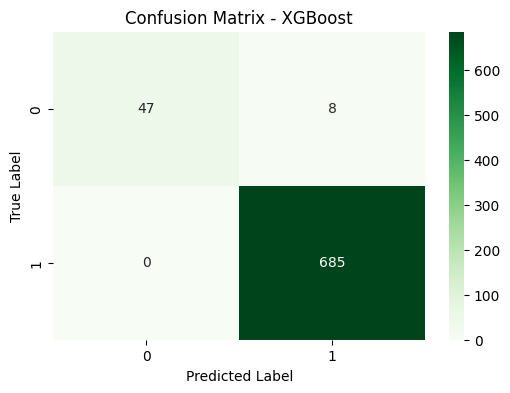


ROC AUC Score: 0.9866


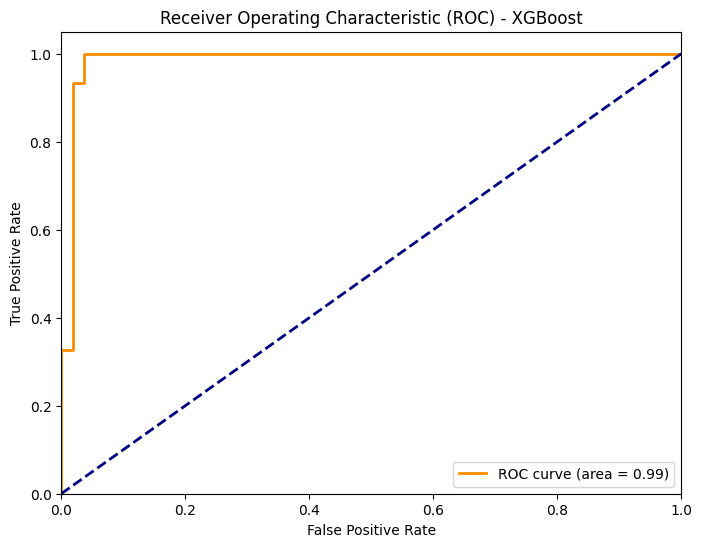

In [14]:
# Evaluate the XGBoost model using the utility function
utils.evaluate_model_performance(y_test, y_pred_xgb, X_test_scaled, xgb_clf, "XGBoost")